In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

from nsec.datasets.swiss_roll import get_swiss_roll
from nsec.datasets.two_moons import get_two_moons
import jax
import jax.numpy as jnp
from jax import ops
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [45]:
dist = get_swiss_roll(.5, 2048)
dist = get_two_moons(.05, 2048)

score = jax.grad(dist.log_prob)

# Langevin dynamics

In [59]:
@jax.jit
def update_langevin(i, args):
    samples, step_size, seed = args
    
    seed, key, _ = jax.random.split(seed, 3)
    
    x = samples[i-1]
    
    noise = jax.random.normal(key, shape=x.shape)
    gradient = score(x)
    
    new_x = x + 0.5 * step_size * gradient + noise * jnp.sqrt(step_size)
    
    samples_updated = ops.index_update(samples, i, new_x)
    
    return samples_updated, step_size, seed

@jax.jit
def langevin(init_sample, n_steps=int(20e4), step_size=.001, seed=jax.random.PRNGKey(0)):
    samples = jnp.zeros((n_steps,2))
    samples = ops.index_update(samples, ops.index[0,:], init_sample)
    langevin_samples, _, _ = jax.lax.fori_loop(1, n_steps, update_langevin, (samples, step_size, seed))
    
    return langevin_samples

In [60]:
init = dist.sample(seed=jax.random.PRNGKey(0))

custom_langevin = jnp.array(langevin(init))

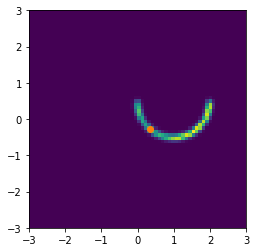

In [61]:
"""
hist2d(custom_langevin[:,0], custom_langevin[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
#scatter(samples_customlangevin[:,0], samples_customlangevin[:,1])
scatter(init[0], init[1], label='x0', color='C1')
"""
hist2d(custom_langevin[:,0], custom_langevin[:,1],64,range=[[-3,3],[-3,3]]); gca().set_aspect('equal')
#scatter(samples_customlangevin[:,0], samples_customlangevin[:,1])
scatter(init[0], init[1], label='x0', color='C1')

## Anneal Langevin Dynamics

In [135]:
@jax.jit
def update_a_langevin(i, args):
    samples, j, n_steps, step_size, seed = args
    
    seed, key, _ = jax.random.split(seed, 3)
    
    x = samples[n_steps*j + i-1]
    
    noise = jax.random.normal(key, shape=x.shape)
    gradient = score(x)
    
    new_x = x + 0.5 * step_size * gradient + noise * jnp.sqrt(step_size)
    
    samples_updated = ops.index_update(samples, n_steps*j + i, new_x)
    
    return samples_updated, j, n_steps, step_size, seed

@jax.jit
def anneal_sigma_loop(j, args):
    (samples, sigmas, step_lr, n_steps, seed) = args

    step_size = step_lr * (sigmas[j] / sigmas[-1]) ** 2
    
    start = jax.lax.cond(j==0, lambda x: 1, lambda x: 0, 0)
    
    langevin_samples, _, _, _, seed = jax.lax.fori_loop(start, n_steps, update_a_langevin, (samples, j, n_steps, step_size, seed))

    return langevin_samples, sigmas, step_lr, n_steps, seed

@jax.jit
def anneal_langevin(init_sample, sigmas, n_steps=int(1e4), step_lr=.001, seed=jax.random.PRNGKey(0)):
    samples = jnp.zeros((n_steps*len(sigmas),2))
    samples = ops.index_update(samples, ops.index[0,:], init_sample)

    langevin_samples, _, _, _, _ = jax.lax.fori_loop(0, len(sigmas), anneal_sigma_loop, (samples, sigmas, step_lr, n_steps, seed))
    
    return langevin_samples

In [136]:
sigma_begin = 0.15
sigma_end = 0.05
num_classes = 10
sigmas_list = jnp.exp(jnp.linspace(jnp.log(sigma_begin), np.log(sigma_end),
                                    num_classes))
#sigmas_list = jnp.zeros(10) + 1e-2
print(sigmas_list)


res_al = jnp.array(anneal_langevin(init, sigmas_list))

[0.15       0.13276324 0.11750715 0.1040042  0.09205287 0.08147492
 0.07211247 0.0638259  0.05649154 0.05      ]


Text(0.5, 1.0, 'annealed langevin')

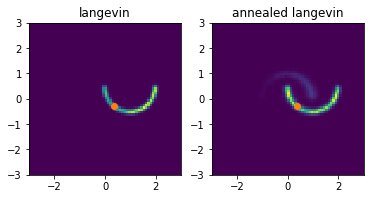

In [137]:
"""
plt.subplot(121)
hist2d(custom_langevin[:,0], custom_langevin[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init[0], init[1], label='x0', color='C1')
plt.title('langevin')
plt.subplot(122)
hist2d(res_al[:,0], res_al[:,1],64,range=[[-15,15],[-15,15]]); gca().set_aspect('equal')
scatter(init[0], init[1], label='x0', color='C1')
plt.title('annealed langevin')
"""

plt.subplot(121)
hist2d(custom_langevin[:,0], custom_langevin[:,1],64,range=[[-3,3],[-3,3]]); gca().set_aspect('equal')
scatter(init[0], init[1], label='x0', color='C1')
plt.title('langevin')
plt.subplot(122)
hist2d(res_al[:,0], res_al[:,1],64,range=[[-3,3],[-3,3]]); gca().set_aspect('equal')
scatter(init[0], init[1], label='x0', color='C1')
plt.title('annealed langevin')